# Effect of misspecification on GBI samples learned via emulator
...and normalizing constant.

Learn an emulator (e.g., SNLE) and sample from that to generate GBI distances, which is then used for GBI sampling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import zeros, ones

from sbi.utils import BoxUniform, likelihood_nn
from sbi.utils.gbi import build_generalized_log_likelihood, GBIPotential, mse_dist
from sbi.inference import SNLE, RejectionPosterior, likelihood_estimator_based_potential

/Users/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'sbi'

### Define simulator, simulate, train emulator

In [3]:
prior = BoxUniform(-ones(2), ones(2))
def simulator(theta):
    return theta ** 2 + torch.randn(theta.shape) * 0.1

In [4]:
_ = torch.manual_seed(0)
theta = prior.sample((1_000,))
x = simulator(theta)

density_estimator = likelihood_nn("nsf")
inference = SNLE(prior, density_estimator=density_estimator)
net = inference.append_simulations(theta, x).train(max_num_epochs=30)

 Training neural network. Epochs trained: 31

### Emulator samples are used to compute distances for theta

In [13]:
generalized_likelihood = build_generalized_log_likelihood(
    emulator=net,
    x_o=-0.5*torch.ones((1,2)),
    dist_func=mse_dist,
    n_per_theta=1_000
)

### Example 1

In [187]:
thetas = torch.linspace(-4, 4, 100)
x = (thetas**2 - 2)**2

xo = -5*ones(1)

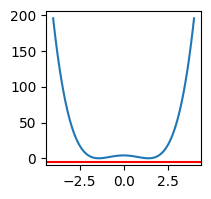

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(thetas.numpy(), x.numpy())
ax.axhline(xo.numpy(), c="r")
plt.show()

In [189]:
likelihoods = torch.distributions.Normal((thetas**2 - 2)**2, 0.1*torch.ones(1))
s = likelihoods.sample((1000,))

In [190]:
dists = (torch.abs(s - xo)).mean(dim=0)

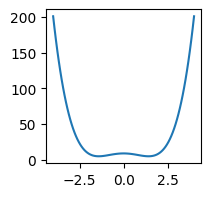

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(thetas.numpy(), dists.numpy())
plt.show()

tensor(0.1118)


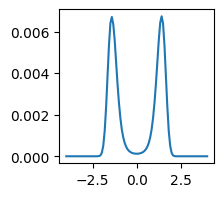

tensor(1.0134)


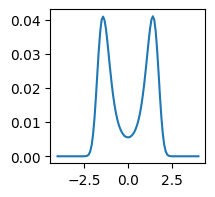

tensor(1.9129)


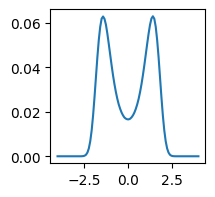

tensor(2.4739)


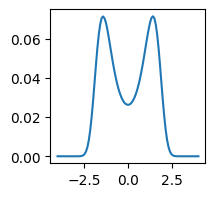

tensor(2.7761)


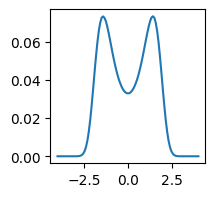

tensor(2.9183)


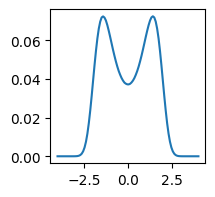

tensor(2.9660)


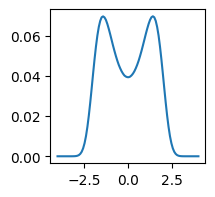

tensor(2.9584)


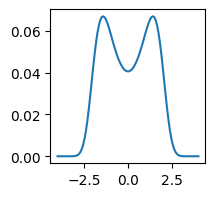

tensor(2.9189)


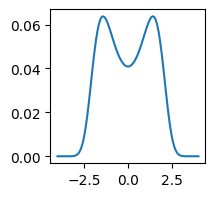

tensor(2.8611)


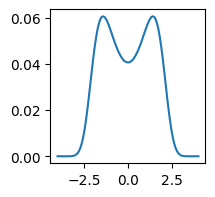

tensor(2.7937)


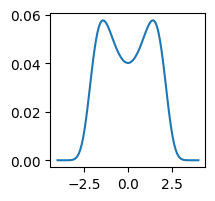

tensor(2.7216)


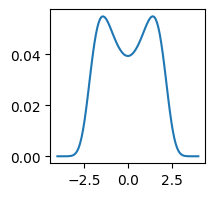

tensor(2.6480)


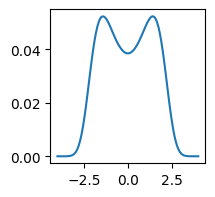

tensor(2.5748)


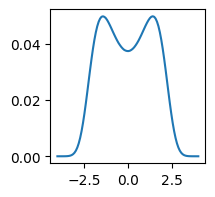

tensor(2.5032)


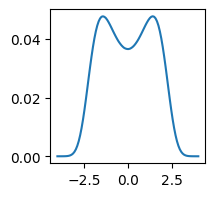

tensor(2.4338)


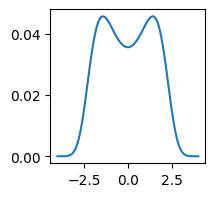

tensor(2.3670)


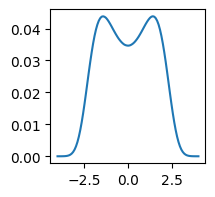

tensor(2.3030)


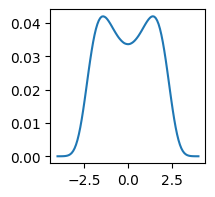

tensor(2.2418)


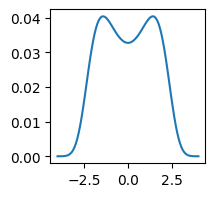

In [280]:
for beta in range(1, 20, 1):
    func1 = torch.exp(-1/beta*dists) / beta
    normalizer = func1.sum()
    print(normalizer)
    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.plot(thetas.numpy(), func1.numpy())
    plt.show()

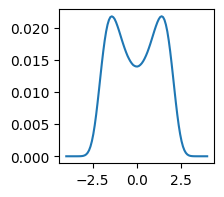

In [272]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(thetas.numpy(), func1.numpy())
plt.show()

### Example 2

In [259]:
xo = torch.zeros(1)
dist1 = torch.distributions.Normal(zeros(1), 10.0*ones(1))
dist2 = torch.distributions.Normal(zeros(1), 1.0*ones(1))

s1 = dist1.sample((10_000,))
s2 = dist2.sample((10_000,))
xos = torch.linspace(-50, 50, 200)
distance1 = (torch.abs(xos - s1)).mean(dim=0)
distance2 = (torch.abs(xos - s2)).mean(dim=0)

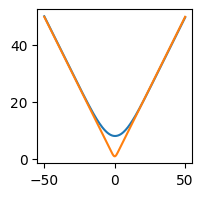

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(xos.numpy(), distance1.numpy())
_ = ax.plot(xos.numpy(), distance2.numpy())
plt.show()

In [237]:
beta = 1.0
func1 = torch.exp(-1/beta*distance1)
func2 = torch.exp(-1/beta*distance2)
# func1 /= torch.sum(func1)
# func2 /= torch.sum(func2)

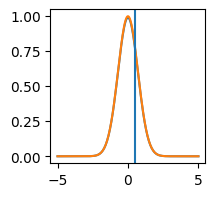

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(xos.numpy(), func1.numpy())
_ = ax.plot(xos.numpy(), func2.numpy())
_ = ax.axvline(xos.numpy()[110])
plt.show()

In [196]:
for beta in range(1, 50, 5):
    func1 = torch.exp(-1/beta*distance1)
    func2 = torch.exp(-1/beta*distance2)
    func1 /= torch.sum(func1)
    func2 /= torch.sum(func2)

    p_of_x = func1[120]
    print(p_of_x)

tensor(5.1478e-09)
tensor(0.0028)
tensor(0.0074)
tensor(0.0099)
tensor(0.0111)
tensor(0.0116)
tensor(0.0118)
tensor(0.0118)
tensor(0.0117)
tensor(0.0116)


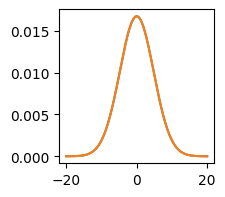

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(xos.numpy(), func1.numpy())
_ = ax.plot(xos.numpy(), func2.numpy())
plt.show()

In [100]:
p_of_x = func1[-1]
print(p_of_x)

tensor(0.0010)


In [30]:
beta_range = torch.logspace(-5, 4, 10)
normalizing_constants = []
for beta in beta_range:
    print("beta", beta)
    gbi_potential = GBIPotential(
        prior=prior,
        gen_llh_fn=generalized_likelihood,
        beta=beta,
    )
    
    # Estimate Z_1(beta)
    theta_samples = prior.sample((1000,))
    x_samples = net.sample(1, context=theta_samples)[0]
    x_probs = net.log_prob(x_samples, context=theta_samples).exp().mean(dim=1)
    z1_of_beta = (gbi_potential(x_samples, track_gradients=False).exp() / x_probs).mean()
    
    # Estimate Z_2
    norm_constant = 0.0
    num_runs = 10
    for _ in range(num_runs):
        prior_samples = prior.sample((10,))
        norm_constant += gbi_potential(prior_samples, track_gradients=False).exp().mean() / z1_of_beta
    norm_constant /= num_runs
    normalizing_constants.append(norm_constant)

beta tensor(1.0000e-05)
beta tensor(1.0000e-04)
beta tensor(0.0010)
beta tensor(0.0100)
beta tensor(0.1000)
beta tensor(1.)
beta tensor(10.)
beta tensor(100.)
beta tensor(1000.)
beta tensor(10000.)


In [31]:
normalizing_constants = torch.stack(normalizing_constants)

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl

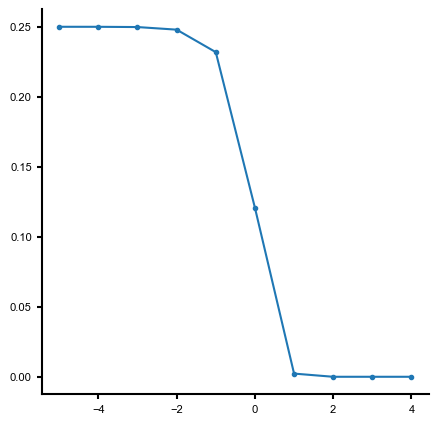

In [33]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(beta_range.log10().numpy(), normalizing_constants.numpy())
    ax.plot(beta_range.log10().numpy(), normalizing_constants.numpy())
    plt.show()